# Deep Learning
## Practical Session 05
Görkem Saygili & Busra Ozgode Yigin, Department of Cognitive Science and Artificial Intelligence – Tilburg University

# Recurrent Neural Networks with Attention Mechanism

In today's practical we will consider two tasks involving sequential data on which RNNs do really excel: (i) a text classification problem that is a many-to-one (sequence-to-one) task and (ii) a text-to-text problem that will serve to illustrate many-to-many (sequence-to-sequence) problems. We will also build text classification models in Keras that use attention mechanism to provide insight into how classification decisions are being made.

For the first exercise, we will go back to the IMDB dataset, this time making actual use of the sequentiality of the data. This will be the opportunity to discover recurrent layers in keras, applying them on a simple NLP task and compare the performance of the updated model by adding an attention layer. In the second part of the notebook, we will look at a more complex task/model to perform additions on strings of characters.


Online resources that are used while preparing this tutorial:

[1] https://analyticsindiamag.com/hands-on-guide-to-bi-lstm-with-attention/

[2] https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html


## Part 1 - Movie Review Classification with LSTMs

As you probably remember, we have worked on the IMDB datasets on our third practical, in which the task was to classify movie review as positive or negative. While the input reviews were sequences of words, we avoided the problem of variable length inputs by converting them to fixed-size vectors (with a representation akin to a bag-of-words representation, except we didn't even use the actual count of each word but just an indicator of presence or absence). Today, we will revisit the same problem, this time using recurrent neural networks which can naturally be applied to sequential data and also considering the Attention Layers. 

The way we vectorized the input data in our previous attempt was suboptimal from two aspects. First, we used one-hot encodings to represent words. Another popular and powerful way to associate a vector with a word is to use a dense "word vector", also called "word embedding". Second, we removed the sequential information which is key in the interpretation of a text.

We will see how to improve on both aspects today.

### Data preprocessing

We will only consider the 5000 most frequent words in the reviews. For computational reasons, we will also restrict ourselves to 2500 reiews for the training set (the same amount of examples is used for the testing set) and will cut all reviews to a maximum of 200 words.

Keras provides function `pad_sequences` that takes care of the padding. We only have to give it the `max_len` argument which will determine the length of the output arrays. If sentences are shorter than this length, they will be padded and if they are longer, they will be trimmed.

In [1]:
from keras.datasets import imdb  
from keras.preprocessing import sequence

# initialization
num_words = 2500  # number of words to consider as features
maxlen = 200  # cut texts after this number of words (among top max_features most common words)

pad_id = 0
start_id = 1
oov_id = 2
index_offset = 2

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, start_char=start_id, oov_char=oov_id, index_from=index_offset)

word2idx = imdb.get_word_index()
idx2word = {v + index_offset: k for k,v in word2idx.items()}

idx2word [pad_id]= '<PAD>'
idx2word [start_id]= '<START>'
idx2word [oov_id]= '<OOV>'

x_train = sequence.pad_sequences(x_train, maxlen=maxlen, truncating='post', padding='post', value=pad_id)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, truncating='post', padding='post', value=pad_id)

# Reducing the size of the dataset
x_train = x_train[:5000]
y_train = y_train[:5000]
x_test = x_test[:5000]
y_test = y_test[:5000]
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

/Users/mertturhan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading data...
x_train shape: (5000, 200)
x_test shape: (5000, 200)


### Word embeddings
While the vectors obtained through one-hot encoding are binary, sparse (mostly composed of zeros) and very high-dimensional (same dimensionality as the number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors (i.e. "dense" vectors, as opposed to sparse vectors). Hence, it is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies, while one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 token in this case). So, word embeddings pack more information into far fewer dimensions.

Another difference lies in the way the two representations are obtained: unlike hard-coded one-hot encodings, word embeddings are learned from data. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load word embeddings into your model that were pre-computed using a different machine learning task than the one you are trying to solve. These are called "pre-trained word embeddings". 

Today, we will restrict ourselves to the first case but we encourage you to look at [word2vec](https://en.wikipedia.org/wiki/Word2vec) (Mikolov et al., 2013) and [GloVe](https://nlp.stanford.edu/projects/glove) (Pennington et al., 2014) which are popular choices for pre-trained word embeddings. The rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets in image classification: We don't have enough data available to learn truly powerful features on our own, but we expect the features that we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a different problem.

### Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific directions in the 
embedding space to be meaningful. 

In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

More 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to learn a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

``` python
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)
```

The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then 
be processed by a RNN layer or a 1D convolution layer (we will focus on the RNN layer today).

When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

### Exercise 1 - Building the LSTM model

Now, create a self attention layer and embed the input sentences as a vector of numbers. There are two main approaches to perform this embedding pre-trained embeddings like Word2Vec or GloVe or randomly initializing. 

In this tutorial, we will be using a random initialization. To perform this embedding we use the `embedding` function from the layers package.The parameters of this matrix will then be trained with the rest of the graph.

Let's apply this idea to our sentiment prediction task. Fill in the `build_model` function. Your model should use 32-dimensional word embeddings. After the embedding layer, we will put an LSTM layer of 64 units. 

In [6]:
from keras.layers import Embedding, Dense, LSTM, Input
from keras.models import Model
from keras.regularizers import l2

### PUT YOUR CODE HERE ###
inputs1 = Input(shape=(maxlen,))

x1= Embedding(num_words, 32, input_length=maxlen, embeddings_regularizer=l2(.001))(inputs1)

recurrent_output = LSTM(64, dropout=0.3, recurrent_dropout=0.2)(x1)

outputs1 = Dense(1, activation='sigmoid')(recurrent_output)

### END ###

model_lstm = Model(inputs1, outputs1)
model_lstm.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 200, 32)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,897 (409.75 KB)

 Trainable params: 104,897 (409.75 KB)

 Non-trainable params: 0 (0.00 B)

Here we have made a model without an attention mechanism. Let’s fit the model on training set and see the results.

In [7]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

#Fit the LSTM model for 10 epoch, batch size of 64, with early stopping
### PUT YOUR CODE HERE ###
lstm_history = model_lstm.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, epochs=10,
                             verbose=1, callbacks=[callback])


### END ###

score, acc = model_lstm.evaluate(x_test, y_test)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - acc: 0.5170 - loss: 0.7228 - val_acc: 0.4914 - val_loss: 0.6941
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - acc: 0.5205 - loss: 0.6931 - val_acc: 0.5038 - val_loss: 0.6937
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - acc: 0.5209 - loss: 0.6924 - val_acc: 0.5002 - val_loss: 0.6949
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - acc: 0.5191 - loss: 0.6990 - val_acc: 0.5318 - val_loss: 0.6929
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - acc: 0.5592 - loss: 0.6899 - val_acc: 0.5522 - val_loss: 0.6888
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - acc: 0.5759 - loss: 0.6886 - val_acc: 0.5566 - val_loss: 0.6898
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - acc: 0.5929 - loss: 0.6795 - val_acc: 0.5750 - val_loss: 0.6836
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - acc: 0.6047 - loss: 0.6695 - val_acc: 0.5462 - val_loss: 0.7085
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - acc: 0.611

The validation accuracy is reaching up to around 54 % with the basic LSTM-based model.

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

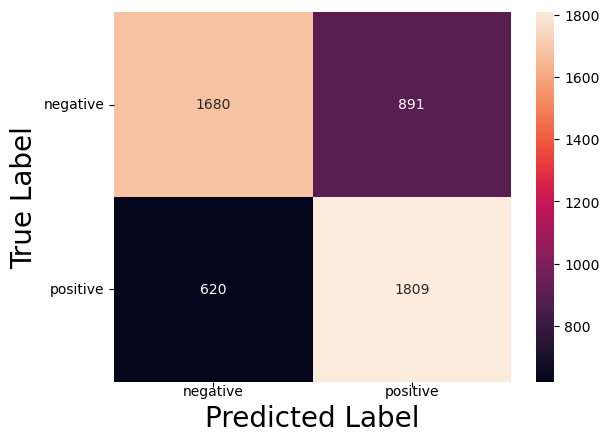

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predict probabilities for test set
yhat_probs = model_lstm.predict(x_test, verbose=1)
# predict classes for test set
yhat_classes = np.where(yhat_probs>0.5, 1, 0)

#Plot the confusion matrix by using heatmap from seaborn

### PUT YOUR CODE HERE ###
p=sns.heatmap(confusion_matrix(y_test, yhat_classes), annot=True, fmt='g')
p.set_xlabel("Predicted Label", fontsize=20)
p.set_ylabel("True Label", fontsize=20)
p.xaxis.set_ticklabels(['negative','positive'], ha="center", va="center")
p.yaxis.set_ticklabels(['negative', 'positive'], rotation=0, va="center")

### END ###

## Exercise 2 - LSTM + attention neural network on IMDB movie reviews

### Create Attention Layer

The basic concept of attention is that not all words contribute equally to the meaning of a sentence. Hence, their contribution must be weighted.

How attention works is that it basically extracts words that are important to the meaning of the sentence and aggregate the representation of those informative words to form a sentence vector.

Let's first create attention class:

All the weights and biases corresponding to a single layer are contained by this class. We need to write the \__init__ method as well as override the following methods:

build(): Keras guide recommends adding weights in this method once the size of the inputs is known. This method creates weights. The builtin function add_weight() can be used to add weights and biases of the attention layer. If any LSTM layer’s output shape is (None, 64, 128) then our output weight and bias will be of (128, 1) shape.

call(): The call() method implements the mapping of inputs to outputs. It will take the product of weights and add the bias terms to flow forward as inputs. After that, the ‘tanh’ is followed by a softmax layer. This softmax layer gives the alignment to the scores.

The get_config() method collects the input shape and other information about the model.

In [21]:
import tensorflow as tf
from keras.layers import Layer

class attention(Layer):
    def __init__(self, **kwargs):
        super(attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer="normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(1,), 
            initializer="zeros",
            trainable=True,
        )
        super(attention, self).build(input_shape)

    def call(self, x):
        et = tf.tanh(tf.matmul(x, self.W) + self.b) 
        et = tf.squeeze(et, axis=-1)  
        at = tf.nn.softmax(et, axis=1)  
        at = tf.expand_dims(at, axis=-1) 
        output = x * at 
        return tf.reduce_sum(output, axis=1)  

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(attention, self).get_config()



Now, let’s try to add this custom Attention layer to our previously defined model. Except for the custom Attention layer, every other layer and their parameters remain the same. Remember, here we should set return_sequences=True in our LSTM layer because we want our LSTM to output all the hidden states.

Our model uses a bi-directional RNN, we first concatenate the hidden states from each RNN before computing the attention weights and applying the weighted sum.

In [22]:
from keras.layers import Embedding, Dense, LSTM, Input
from keras.models import Model
from keras.regularizers import l2

### PUT YOUR CODE HERE ###

inputs=Input((maxlen,))
x = Embedding(num_words, 32, input_length=maxlen, embeddings_regularizer = l2(.001))(inputs)
att_in = LSTM(64, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2)(x)
att_out = attention()(att_in)
outputs = Dense(1, activation='sigmoid', trainable = True)(att_out)



### END ###
model_attention = Model(inputs, outputs)

model_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_attention.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_10 (Embedding)        │ (None, 200, 32)        │        80,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 200, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (attention)         │ (None, 64)             │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,962 (410.01 KB)

 Trainable params: 104,962 (410.01 KB)

 Non-trainable params: 0 (0.00 B)

Let's fit the model with attention and see the results:

In [23]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

#Fit the model with attention for 10 epoch, batch size of 64, with early stopping

### PUT YOUR CODE HERE ###
history_att = model_attention.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10, 
                                  batch_size = 64, verbose = 1, callbacks = [callback])


### END ###

result = model_attention.evaluate(x_test, y_test)
print(result)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.5105 - loss: 0.7214 - val_accuracy: 0.5760 - val_loss: 0.6880
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - accuracy: 0.6208 - loss: 0.6683 - val_accuracy: 0.7712 - val_loss: 0.5291
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - accuracy: 0.7904 - loss: 0.5213 - val_accuracy: 0.8010 - val_loss: 0.4888
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.8387 - loss: 0.4449 - val_accuracy: 0.8048 - val_loss: 0.4877
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.8609 - loss: 0.4037 - val_accuracy: 0.8116 - val_loss: 0.4792
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8870 - loss: 0.3719 - val_accuracy: 0.8050 - val_loss: 0.5153
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - accuracy: 0.8967 - loss: 0.3477 - val_accuracy: 0.8024 - val_loss: 0.5064
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9133 - loss: 0.3237 - val_accuracy

[Text(0, 0.5, 'negative'), Text(0, 1.5, 'positive')]

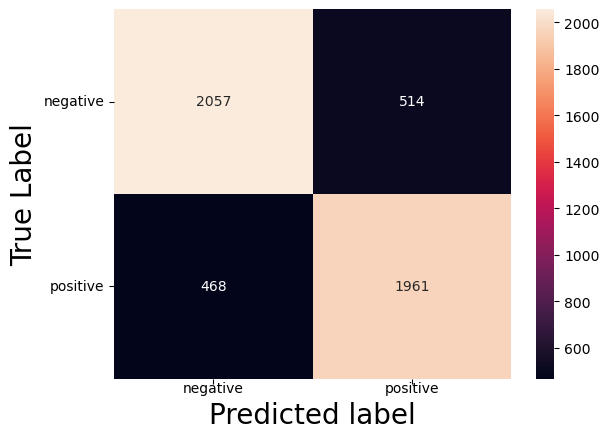

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# predict probabilities for test set
yhat_probs = model_attention.predict(x_test, verbose=0)
# predict classes for test set
yhat_classes = np.where(yhat_probs>0.5, 1, 0)

#Plot the confusion matrix by using heatmap from seaborn

### PUT YOUR CODE HERE ###
p = sns.heatmap(confusion_matrix(y_test, yhat_classes), annot=True, fmt='g')
p.set_xlabel("Predicted label", fontsize = 20)
p.set_ylabel("True Label", fontsize = 20)
p.xaxis.set_ticklabels(['negative', 'positive'], ha="center", va="center")
p.yaxis.set_ticklabels(['negative', 'positive'], rotation=0, va="center")

### END ###

There is indeed an improvement in the performance as compared to the previous model. The validation accuracy now reaches up to 79 % after the addition of the custom Attention layer. With further pre-processing and a grid search of the parameters, we can definitely improve this further.

## Part 2 - Sequence-to-sequence learning for performing additions

### What is sequence-to-sequence learning?

Sequence-to-sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in English) to sequences in another domain (e.g. the same sentences translated to French).

```
"the cat sat on the mat" -> [Seq2Seq model] -> "le chat etait assis sur le tapis"
```

There are multiple ways to handle this task, either using RNNs or using 1D convnets. Here we will focus on RNNs.

In the general case, input sequences and output sequences have different lengths (e.g. machine translation or free-form question answering) and the entire input sequence is required in order to start predicting the target. Here's how it works:

A RNN layer (or stack thereof) acts as "encoder": it processes the input sequence and returns its own internal state. Note that we discard the outputs of the encoder RNN, only recovering the state. This state will serve as the "context", or "conditioning", of the decoder in the next step.

Another RNN layer (or stack thereof) acts as "decoder": it is trained to predict the next tokens of the target sequence, given previous tokens of the target sequence. For training specifically, the previous tokens of the ground-truth sequence are usually used instead of the predicted ones. This strategy, called "teacher forcing" is particularly useful at the beginning of the training when the predictions of the model are random. Importantly, the decoder uses as initial state the state vector from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate target[t+1] given targets[0, ..., t], conditioned on the input sequence.

Here is an illustration of the process applied to free-form question answering. `<SOS>` and `<EOS>` are special tokens used to signal the start and end of a sequence.

![Example of a sequence-to-sequence model for free-form question answering.](seq2seq_model.png)

In inference mode, i.e. when we want to decode unknown input sequences, we go through a slightly different process:

    1) Encode the input sequence into state vector.
    2) Start with a target sequence of size 1 (just the start-of-sequence token).
    3) Feed the state vector and 1-word target sequence to the decoder to produce predictions for the next token.
    4) Sample the next token using these predictions (we simply use argmax).
    5) Append the sampled token to the target sequence
    6) Repeat until we generate the end-of-sequence token or we hit the token limit.

This way of doing inference by selecting the token with highest probability at each time step is called "greedy decoding". Optimizing token by token and not for the whole sequence is suboptimal but more computationally efficient. An alternative would be to consider a few options (in the case of word generation with a large vocabulary, considering all options is intractable) and compute the following sequence for each of them, then choose the sequence with highest overall probability. This technique, called "beam decoding" is often used in speech recognition for example.

### Task definition

Let's illustrate these ideas with actual code. In order to keep computations tractable even on the server, we will consider a simple task: performing addition. The model will take sequences of characters ([0123456789+]) corresponding to an addition as input and generate the answer as another sequence of characters (e.g. "12 + 9" → "21").

Here's a summary of our process:

    1) Turn the sentences into 3 Numpy arrays, encoder_input_data, decoder_input_data, decoder_target_data:
        encoder_input_data is a 3D array of shape (num_pairs, max_query_sequence_length, num_tokens) containing a one-hot vectorization of the queries.
        decoder_input_data is a 3D array of shape (num_pairs, max_answer_sequence_length, num_tokens) containg a one-hot vectorization of the answers.
        decoder_target_data is the same as decoder_input_data but offset by one timestep. decoder_target_data[:, t, :] will be the same as decoder_input_data[:, t + 1, :].
    2) Train a basic GRU-based Seq2Seq model to predict decoder_target_data given encoder_input_data and decoder_input_data. Our model uses teacher forcing.
    3) Decode some sentences to check that the model is working (i.e. turn samples from encoder_input_data into corresponding samples from decoder_target_data).

Because the training process and inference process (decoding sentences) are quite different, we use different models for both, albeit they all leverage the same inner layers.

But let's first generate the data:

In [35]:

from charactertable import CharacterTable
from additions_dataset import load_data


# Parameters for dataset.
num_examples = 1000
max_num_digits = 2
maxlen_input = 2 * max_num_digits + 1
reverse = False
# All the numbers, plus sign and s/e for <SOS>/<EOS>.
chars = '0123456789+se'
ctable = CharacterTable(chars) #we initialize character table with those characters

print('Generating data...')
questions, expected = load_data(num_examples, max_num_digits, reverse)
print('Total addition questions:', len(questions))

print('Vectorization...')
x = np.zeros((len(questions), maxlen_input, ctable.num_tokens))
y = np.zeros((len(questions), max_num_digits + 3, ctable.num_tokens))
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, maxlen_input)
# Characters 's' and 'e' correspond to <SOS> and <EOS>
for i, sentence in enumerate(expected):
    y[i] = ctable.encode('s' + sentence + 'e', max_num_digits + 3) #C: string, to be encoded.
                    #num_rows: Number of rows in the returned one-hot encoding. This is used to keep the # of rows for each data the same.
    
# Explicitly set apart 10% for validation and test data.
num_examples_val = len(x) // 10
split_at_val = len(x) - num_examples_val * 2
split_at_test = len(x) - num_examples_val
x_train = x[:split_at_val]
y_train = y[:split_at_val]
x_val = x[split_at_val:split_at_test]
y_val = y[split_at_val:split_at_test]
x_test = x[split_at_test:]
y_test = y[split_at_test:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)
print('Validation Data:')
print(x_val.shape)
print(y_val.shape)
print('Test Data:')
print(x_test.shape)
print(y_test.shape)

Generating data...
Total addition questions: 1000
Vectorization...
Training Data:
(800, 5, 14)
(800, 5, 14)
Validation Data:
(100, 5, 14)
(100, 5, 14)
Test Data:
(100, 5, 14)
(100, 5, 14)


Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument.

### Exercise 3 - Building the model for training

Let's now build our training model. Because our model is not simply a stack of layers, we can't use the `Sequential` class, but should rather use the `Model` class (see https://keras.io/models/model). The model we will build should also leverage three key features of Keras RNNs:

* The return_state contructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the internal RNN states. This is used to recover the states of the encoder.
* The inital_state call argument, specifying the initial state(s) of a RNN. This is used to pass the encoder states to the decoder as initial states.
* The return_sequences constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which the defaults behavior). This is used in the decoder.

We wrote the code for the encoder, leaving the decoder for you to define. The model is finally composed from the two components and compiled.





In [28]:
from keras.models import Model
from keras.layers import Input, Dense, GRU

# Parameters for the model.
hidden_size = 32

# Define an input sequence and process it.
encoder_inputs = Input(shape=(maxlen_input, ctable.num_tokens))
encoder_rnn_layer = GRU(hidden_size, return_state=True)
# We discard the output of the layer and only keep the states.
_, encoder_state = encoder_rnn_layer(encoder_inputs)

### UPDATE CODE HERE ###
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, ctable.num_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_rnn_layer = GRU(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _ = decoder_rnn_layer(decoder_inputs,
                                       initial_state=encoder_state)
decoder_dense = Dense(ctable.num_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
### END ###

# Define the model that will turn
# `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 5, 14)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, None, 14)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ [(None, 32),      │      4,608 │ input_layer_11[0… │
│                     │ (None, 32)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, None,     │      4,608 │ input_layer_12[0… │
│                     │ 32), (None, 32)]  │            │ gru[0][1]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 14)  │        462 │ gru_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,678 (37.80 KB)

 Trainable params: 9,678 (37.80 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

We can now train the model and plot the result. Bur first, let's see the shape of our input and target data:

In [29]:
print(x_train[0,:,:]) #x_train will be our encoder_input_data (num_pairs, max_query_sequence_length, num_tokens)
print(y_train[0, :, :-1]) # y_train[:, :-1] will be our decoder_input_data (num_pairs, max_answer_sequence_length, num_tokens)
print(y_train[0, :, 1:])# y_train[:, 1:] will be our decoder_target_data is the same as decoder_input_data but offset by one timestep.

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [30]:
num_epochs = 100
batch_size = 16

history = model.fit([x_train, y_train[:, :-1]], y_train[:, 1:], #[encoder_input_data, decoder_input_data], decoder_target_data
                    batch_size=batch_size,
                    epochs=num_epochs,
                    validation_data=([x_val, x_val[:, :-1]], y_val[:, 1:]),
                    verbose=2)

Epoch 1/100


/Users/mertturhan/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_32', 'keras_tensor_35']. Received: the structure of inputs=('*', '*')
  warnings.warn(


50/50 - 1s - 19ms/step - accuracy: 0.3963 - loss: 2.3917 - val_accuracy: 0.3900 - val_loss: 2.2139
Epoch 2/100
50/50 - 0s - 2ms/step - accuracy: 0.4653 - loss: 1.9259 - val_accuracy: 0.4075 - val_loss: 1.9101
Epoch 3/100
50/50 - 0s - 1ms/step - accuracy: 0.5369 - loss: 1.6683 - val_accuracy: 0.4250 - val_loss: 1.7727
Epoch 4/100
50/50 - 0s - 2ms/step - accuracy: 0.5369 - loss: 1.5064 - val_accuracy: 0.4500 - val_loss: 1.7203
Epoch 5/100
50/50 - 0s - 2ms/step - accuracy: 0.5381 - loss: 1.4015 - val_accuracy: 0.4625 - val_loss: 1.6928
Epoch 6/100
50/50 - 0s - 2ms/step - accuracy: 0.5400 - loss: 1.3407 - val_accuracy: 0.4675 - val_loss: 1.7264
Epoch 7/100
50/50 - 0s - 2ms/step - accuracy: 0.5447 - loss: 1.3046 - val_accuracy: 0.4675 - val_loss: 1.7368
Epoch 8/100
50/50 - 0s - 1ms/step - accuracy: 0.5506 - loss: 1.2798 - val_accuracy: 0.4625 - val_loss: 1.7648
Epoch 9/100
50/50 - 0s - 1ms/step - accuracy: 0.5534 - loss: 1.2626 - val_accuracy: 0.4550 - val_loss: 1.9388
Epoch 10/100
50/50 - 

Epoch 75/100
50/50 - 0s - 2ms/step - accuracy: 0.7362 - loss: 0.7580 - val_accuracy: 0.5200 - val_loss: 2.2947
Epoch 76/100
50/50 - 0s - 2ms/step - accuracy: 0.7319 - loss: 0.7541 - val_accuracy: 0.5050 - val_loss: 2.3180
Epoch 77/100
50/50 - 0s - 1ms/step - accuracy: 0.7378 - loss: 0.7487 - val_accuracy: 0.5150 - val_loss: 2.3376
Epoch 78/100
50/50 - 0s - 1ms/step - accuracy: 0.7362 - loss: 0.7461 - val_accuracy: 0.4975 - val_loss: 2.2344
Epoch 79/100
50/50 - 0s - 1ms/step - accuracy: 0.7366 - loss: 0.7435 - val_accuracy: 0.5050 - val_loss: 2.3101
Epoch 80/100
50/50 - 0s - 1ms/step - accuracy: 0.7400 - loss: 0.7382 - val_accuracy: 0.5200 - val_loss: 2.3732
Epoch 81/100
50/50 - 0s - 2ms/step - accuracy: 0.7453 - loss: 0.7335 - val_accuracy: 0.5200 - val_loss: 2.3834
Epoch 82/100
50/50 - 0s - 2ms/step - accuracy: 0.7459 - loss: 0.7300 - val_accuracy: 0.5100 - val_loss: 2.4041
Epoch 83/100
50/50 - 0s - 1ms/step - accuracy: 0.7447 - loss: 0.7263 - val_accuracy: 0.5075 - val_loss: 2.3711
E

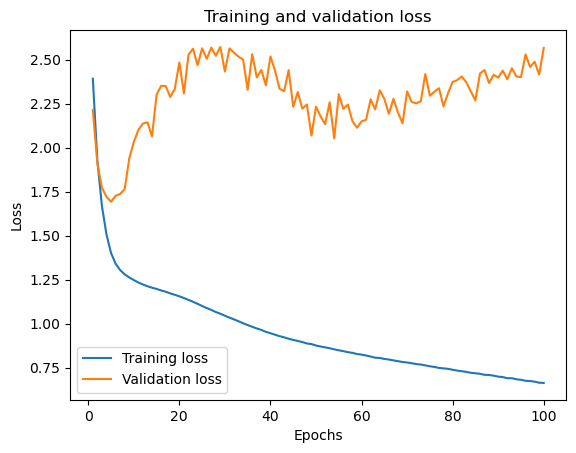

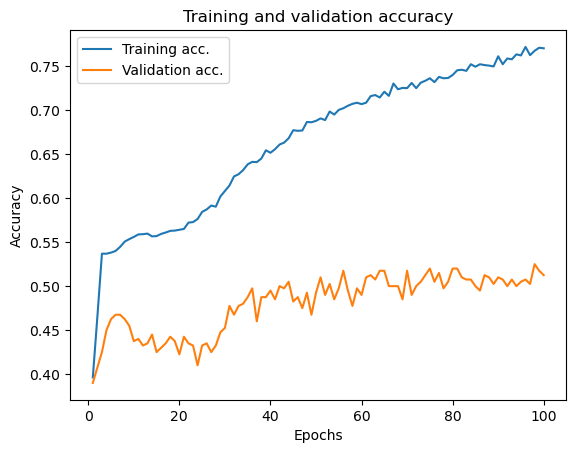

In [31]:
import matplotlib.pyplot as plt

def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()
    
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#Plot the history of loss and accuracy during epochs
### PUT YOUR CODE HERE ###
plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', 'Validation acc.'],
             title='Training and validation accuracy',
             ylabel='Accuracy')

### END ###

Performance is not amazing (you should reach around 50-52% of validation accuracy) but far from random (random guess is 1/14 as we have 14 tokens). We could easily reach higher performances by using more training examples and more units in the recurrent layers, but training would start to be prohibitively long on the server. For example, with 2000 examples and 128 hidden units in both encoder and decoder, we easily reached above 70% of accuracy (~72-73%). You can try that out if you are working on your own computer or have time.

### Exercise 4 - Building the model for inference

At training time, we can use ground-truth labels as input for the decoder (teacher-forcing). This is not an option at test time though, where we should use predictions from one step to compute the next token. Define the decoder model that will be used later to perform inference. It should take a `decoder_state_input` (fed with the last state of the decoder or the state of the encoder when starting inference), the `decoder_inputs` (which will be composed of the prediction from previous step or `<SOS>` when starting inference) and produces a new prediction `decoder_outputs` and a new state `decoder_state`.

In [32]:
encoder_model = Model(encoder_inputs, encoder_state)

### PUT YOUR CODE HERE ###
decoder_state_input = Input(shape=(hidden_size,))
decoder_outputs, decoder_state = decoder_rnn_layer(decoder_inputs, initial_state=decoder_state_input)
decoder_outputs = decoder_dense(decoder_outputs)
### END ###
decoder_model = Model([decoder_inputs, decoder_state_input], [decoder_outputs, decoder_state])

### Perform inference

We can finally define the `decode_sequence` function that actually performs inference, taking a query as input and produces an answer. The inference stops when the decoder produces the <EOS> token or when the output reaches the maximum length (`max_decoder_seq_length`).

In [33]:
def decode_sequence(input_seq, max_decoder_seq_length):
    # Encode the input as state vectors.
    state_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, ctable.num_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, ctable.char_indices['s']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, state_value = decoder_model.predict(
            [target_seq, state_value])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = ctable.indices_char[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == 'e' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, ctable.num_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

    return decoded_sentence

To test the function, let's try decode a few test examples.

In [34]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'
    
# Select 10 samples from the validation set at random so we can visualize
# errors.
for i in range(10):
    ind = np.random.randint(0, len(x_test))
    q, ea = x_test[np.array([ind])], y_test[np.array([ind])]
    pred = decode_sequence(q, max_num_digits + 2)[:-1]
    q = ctable.decode(q[0])
    correct = ctable.decode(ea[0])[1:-1]
    print('Q', q[::-1] if reverse else q, end=' ')
    print('T', correct, end=' ')
    if correct == pred:
        print(colors.ok + '☑' + colors.close, end=' ')
    else:
        print(colors.fail + '☒' + colors.close, end=' ')
    print(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Q 57+28 T 85 ☒ 88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Users/mertturhan/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_35', 'keras_tensor_39']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Q 23+27 T 50 ☒ 52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Q 53+46 T 99 ☑ 99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Q 36+46 T 82 ☒ 88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Q 30+3 T 33 ☒ 35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Q 19+78 T 97 ☒ 99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Q 73+82 T 155 ☒ 147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/s

## Wrapping Up

In this practical we have seen how to use Word Embeddings and how to add Attention Mechanism into the Recurrent Neural Networks.

Here's what you should take away from this example:

* Keras supports word embeddings via the Embedding layer.
* The method build() is required to add weights to the attention layer.
* The call() method is required for specifying the mapping of inputs to outputs of the attention layer.
* You can add a custom attention layer to the deep learning network built using any kind of RNN.


The Steps for Sequence-to-sequence learning:

Encoder:

* Receives the input sequence
* It consumes the tokens at each time steps
* After finishing all tokens in the input sequence, Encoder outputs **encoder state** ***as the context vector***.
* Encoder stops 

Decoder:

* Decoder produce the output sequece one by one 
* For each output, the decoder consumes a context vector and an input
* The **initial context** vector is created by the **encoder**
* The **initial input to the decoder** is a special symbol for decoder to make it start, e.g. '***\<SOS>***'
* Using initial context and initial input, the decoder will generate/predict the **first output**
* For the next time step, decoder will use  **its own encoder state** ***as context vector*** and **generated/predicted output at the previous time step** as ***input***
* Decoder will work in such a **loop** using its states and output as the next step context vector and input **until**:
  * the generated output is a special symbol (e.g. '***\<EOS>***') or 
  * the ***pre-defined maximum steps*** (length of output) is reached.
